# Import modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import joblib
import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# метрики
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

# регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor

# классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier
from catboost import CatBoostClassifier

# Chapter I. Preprocessing data

In [8]:
data = pd.read_csv('data/epi_r.csv')
data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
columns = data.columns.tolist()
print(columns)

['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alabama', 'alaska', 'alcoholic', 'almond', 'amaretto', 'anchovy', 'anise', 'anniversary', 'anthony bourdain', 'aperitif', 'appetizer', 'apple', 'apple juice', 'apricot', 'arizona', 'artichoke', 'arugula', 'asian pear', 'asparagus', 'aspen', 'atlanta', 'australia', 'avocado', 'back to school', 'backyard bbq', 'bacon', 'bake', 'banana', 'barley', 'basil', 'bass', 'bastille day', 'bean', 'beef', 'beef rib', 'beef shank', 'beef tenderloin', 'beer', 'beet', 'bell pepper', 'berry', 'beverly hills', 'birthday', 'biscuit', 'bitters', 'blackberry', 'blender', 'blue cheese', 'blueberry', 'boil', 'bok choy', 'bon appétit', 'bon app��tit', 'boston', 'bourbon', 'braise', 'bran', 'brandy', 'bread', 'breadcrumbs', 'breakfast', 'brie', 'brine', 'brisket', 'broccoli', 'broccoli rabe', 'broil', 'brooklyn', 'brown rice', 'brown

Получили все столбцы, тепрь у нейронки попросим чтобы написала столбцы не ингридиенты и вручную отрегулируем. Получим список столбцов которые нужно дропнуть, короме таргета - ratings

In [10]:
non_ingredients =[
    'title', 'calories', 'protein', 'fat', 'sodium', '#cakeweek', '#wasteless', 
    '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 
    'alabama', 'alaska', 'alcoholic', 'anniversary', 'anthony bourdain', 'aperitif', 
    'appetizer', 'arizona', 'aspen', 'atlanta', 'australia', 'back to school', 
    'backyard bbq', 'bake', 'bastille day', 'beverly hills', 'birthday', 'blender', 
    'boil', 'bon appétit', 'bon app��tit','bon appétit', 'boston', 'braise', 'breakfast', 'brine', 
    'broil', 'brooklyn', 'brunch', 'buffet', 'bulgaria', 
    'california', 'cambridge', 'camping', 'canada', 'candy thermometer', 'casserole/gratin', 
    'chicago', 'chill', 'christmas', 'christmas eve', 'cinco de mayo', 'cobbler/crumble', 
    'cocktail', 'cocktail party', 'coffee grinder', 'colorado', 'columbus', 
    'connecticut', 'cook like a diner', 'cookbook critic', 
    'costa mesa', 'cuba', 'dairy free', 'dallas', 'deep-fry', 'denver', 
    'dessert', 'digestif', 'dinner', 'dip', 'diwali', 'dominican republic', 
    'dorie greenspan', 'double boiler', 'drink', 'drinks', 'easter', 'edible gift', 
    'egg nog', 'egypt', 'emeril lagasse', 'engagement party', 'england', 'entertaining', 
    'epi + ushg', 'epi loves the microwave', 'fall', 'family reunion', 'fat free', 
    "father's day", 'flaming hot summer', 'florida', 
    'food processor', 'fourth of july', 'france', 'frankenrecipe', 'freeze/chill', 
    'freezer food', 'friendsgiving', 'frozen dessert', 'fry', 'georgia', 
    'germany', 'gourmet', 'graduation', 'guam', 'haiti', 'halloween', 'hanukkah', 
    'harpercollins', 'hawaii', 'healdsburg', 'healthy', 'high fiber', 'hollywood', 
    'hominy/cornmeal/masa', "hors d'oeuvre", 'hot drink', 'house & garden', 
    'house cocktail', 'houston', 'ice cream machine', 'iced coffee', 'iced tea', 
    'idaho', 'illinois', 'indiana', 'iowa', 'ireland', 'israel', 'italy', 'jamaica', 
    'japan', 'juicer', 'kansas', 'kansas city', 'kentucky', 'kentucky derby', 
    'kid-friendly', 'kidney friendly', 'kitchen olympics', 'kosher', 
    'kosher for passover', 'kwanzaa', 'labor day', 'lancaster', 'las vegas', 
    'london', 'long beach', 'los angeles', 'louisiana', 'louisville', 'low cal', 
    'low carb', 'low cholesterol', 'low fat', 'low sodium', 'low sugar', 
    'low/no sugar', 'lunar new year', 'lunch', 'maine', 'mandoline', 'mardi gras', 
    'marinade', 'marinate', 'martini', 'maryland', 'massachusetts', 
    'mexico', 'miami', 'michigan', 'microwave', 'midori', 'minneapolis', 
    'minnesota', 'mississippi', 'missouri', 'mixer', 'mortar and pestle', 
    "mother's day", 'nancy silverton', 'nebraska', 'new hampshire', 'new jersey', 
    'new mexico', 'new orleans', "new year's day", "new year's eve", 'new york', 
    'no meat, no problem', 'no sugar added', 'no-cook', 'non-alcoholic', 'noodle', 
    'north carolina', 'ohio', 'oklahoma', 'oktoberfest', 'one-pot meal', 
    'organic', 'oscars', 'pacific palisades', 'paleo', 'pan-fry', 'parade', 
    'paris', 'party', 'pasadena', 'passover', 'pasta maker', 'pastry', 
    'peanut free', 'pennsylvania', 'peru', 'pescatarian', 'philippines', 
    'picnic', 'pittsburgh', 'poker/game night', 'portland', 'potato salad', 
    'potluck', 'pressure cooker', 'providence', 'purim', 'quick & easy', 
    'quick and healthy', 'ramadan', 'ramekin', 'raw', 'rhode island', 'roast', 
    'rosh hashanah/yom kippur', 'rub', 'salad dressing', 'san francisco', 
    'sandwich', 'sandwich theory', 'sangria', 'santa monica', 'sauté', 
    'seattle', 'self', 'shavuot', 'shower', 'side', 'simmer', 'skewer', 
    'slow cooker', 'smoker', 'smoothie', 'soufflé/meringue', 'soup/stew', 
    'south carolina', 'soy free', 'spain', 'spring', 'spritzer', 'st. louis', 
    "st. patrick's day", 'steam', 'stir-fry', 'stock', 'stuffing/dressing', 
    'sugar conscious', 'sukkot', 'summer', 'super bowl', 'suzanne goin', 
    'switzerland', 'tailgating', 'tested & improved', 'texas', 'thanksgiving', 
    'tree nut free', 'utah', "valentine's day", 'vegan', 'vegetarian', 
    'vermont', 'virginia', 'washington', 'washington, d.c.', 'wedding', 
    'weelicious', 'west virginia', 'westwood', 'wheat/gluten-free', 
    'whole wheat', 'windsor', 'winter', 'wisconsin', 'wok', 'yonkers', 
    'cookbooks', 'leftovers', 'snack', 'snack week'
]

In [11]:
data = data.drop(columns=non_ingredients)
data.head()

,rating,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,arugula,...,watermelon,whiskey,white wine,wild rice,wine,yellow squash,yogurt,yuca,zucchini,turkey
0,2.500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


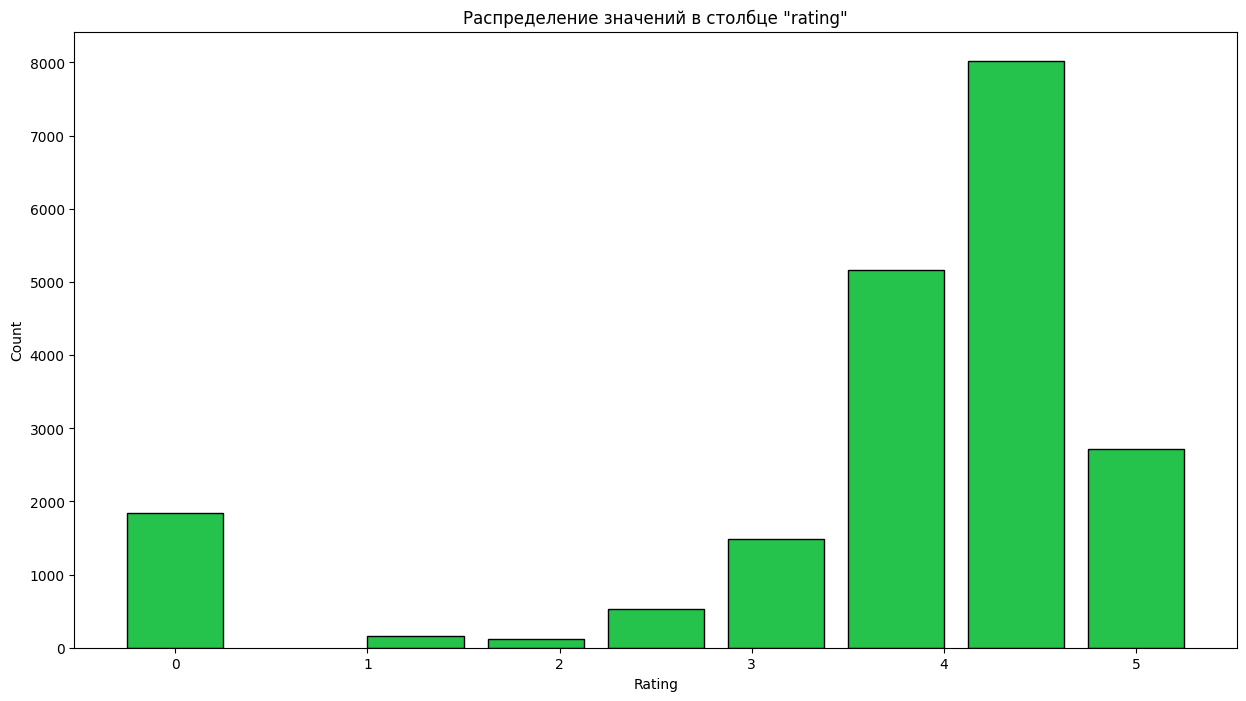

In [12]:
rating_distribution = data['rating'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(rating_distribution.index, rating_distribution.values, color='#25c24c', edgecolor='black', width=0.5)

plt.title('Распределение значений в столбце "rating"')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

большинство оценок примерно в диапазоне от 3.5 до 4.7

проверка на nan

In [13]:
columns_with_nan = data.columns[data.isna().any()].tolist()
columns_with_nan

[]

пропусков нет

преобразуем столбцы с ингредиентами из типа float64 в тип int8. уменьшим место в памяти занимаемое датасетом

In [14]:
for column in data.select_dtypes(include=['float']).columns:
    if column != 'rating':  
        data[column] = data[column].astype('int8')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 380 entries, rating to turkey
dtypes: float64(1), int8(379)
memory usage: 7.4 MB


In [15]:
data.head(3)

,rating,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,arugula,...,watermelon,whiskey,white wine,wild rice,wine,yellow squash,yogurt,yuca,zucchini,turkey
0,2.500,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4.375,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.750,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = data.drop(columns=['rating'])
y = data['rating']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,stratify=y, random_state=21)

# Chapter II. Regression

## Individual Regression models

напишем функцию которая принимает объекты GridSearcCV(в нем уже реализована кросс-валидация) и выводит название лучшей модели

In [18]:
def choose_model(grid_models, models_name, X_train, X_test, y_train, y_test):
    
    best_rmse = 1000
    best_model_name = ''
    
    for index, model_name in models_name.items():
        
        grid_model = grid_models[index]
        
        grid_model.fit(X_train, y_train)
        
        best_model = grid_model.best_estimator_
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        print(f'Model: {model_name}')
        print(f'Best params: {grid_model.best_params_}')
        print(f'Train RMSE: {rmse_train:.4f}')
        print(f'Test RMSE: {rmse_test:.4f}')
        print(f'Crossval best result: {-grid_model.best_score_:.4f}')
        print('-------------------------------')
        
        if rmse_test < best_rmse:
            best_rmse = rmse_test
            best_model_name = model_name
            
    print(f'Best model is {best_model_name}')
        

инициализируем наши модели

In [19]:
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=21)
random_forest_model = RandomForestRegressor(random_state=21)
ridge_model = Ridge(random_state=21)
lasso_model = Lasso(random_state=21)

linear_param_grid = {
    'fit_intercept': [True, False],
}

decision_tree_param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
}

lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
}

linear_grid = GridSearchCV(linear_model, param_grid=linear_param_grid, 
                           cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
dtr_grid = GridSearchCV(decision_tree_model, param_grid=decision_tree_param_grid, 
                        cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rfr_grid = GridSearchCV(random_forest_model, param_grid=random_forest_param_grid, 
                        cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_grid = GridSearchCV(lasso_model, param_grid=lasso_param_grid, 
                          cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid = GridSearchCV(ridge_model, param_grid=ridge_param_grid, 
                          cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grids = [linear_grid, dtr_grid, rfr_grid, lasso_grid, ridge_grid]

grids_dict = {
    0: 'LinearRegression',
    1: 'DecisionTreeRegressor',
    2: 'RandomForestRegressor',
    3: 'Lasso',
    4: 'Ridge'
}

In [20]:
choose_model(grids, grids_dict, X_train, X_test, y_train, y_test)

Model: LinearRegression
Best params: {'fit_intercept': True}
Train RMSE: 1.2374
Test RMSE: 1.3035
Crossval best result: 1.2781
-------------------------------
Model: DecisionTreeRegressor
Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Train RMSE: 1.2892
Test RMSE: 1.3112
Crossval best result: 1.3012
-------------------------------
Model: RandomForestRegressor
Best params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Train RMSE: 1.0951
Test RMSE: 1.2704
Crossval best result: 1.2702
-------------------------------
Model: Lasso
Best params: {'alpha': 0.1, 'fit_intercept': True}
Train RMSE: 1.3408
Test RMSE: 1.3406
Crossval best result: 1.3408
-------------------------------
Model: Ridge
Best params: {'alpha': 10.0, 'fit_intercept': True}
Train RMSE: 1.2437
Test RMSE: 1.2899
Crossval best result: 1.2713
-------------------------------
Best model is RandomForestRegressor


Получили модель с лучшей метрикой

In [21]:
best_regressor = RandomForestRegressor(random_state=21,max_depth=None, min_samples_leaf=4, 
                                         min_samples_split=10, n_estimators=100)

best_regressor.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10, random_state=21)

RMSE на тестовой выборке:

In [22]:
y_pred = best_regressor.predict(X_test)
        
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.2704


RMSE на всем датасете:

In [23]:
y_pred = best_regressor.predict(X)
        
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.1324


In [24]:
y_pred_df = pd.DataFrame(y_pred, columns=['rating'])

rating_pred = y_pred_df['rating'].value_counts()

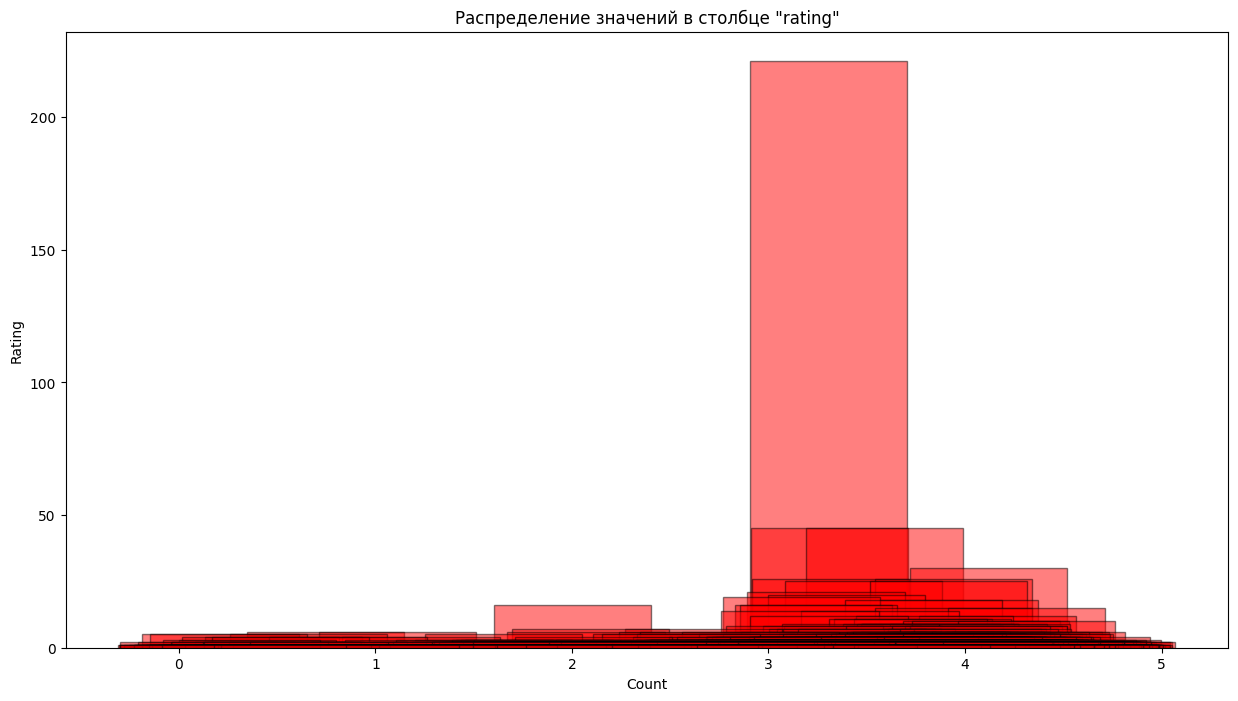

In [25]:
plt.figure(figsize=(15, 8))
#plt.bar(rating_distribution.index, rating_distribution.values, color='#25c24c', edgecolor='black', width=0.5)
plt.bar(rating_pred.index, rating_pred.values, color='red', edgecolor='black', width=0.8, alpha=0.5)

plt.title('Распределение значений в столбце "rating"')
plt.xlabel('Count')
plt.ylabel('Rating')

plt.show()

# Ensembles Regression models

## Voiting

In [26]:
linear = LinearRegression(fit_intercept=True)
ridge = Ridge(random_state=21, alpha=10.0, fit_intercept=True)
forest = RandomForestRegressor(random_state=21, max_depth=None, min_samples_leaf=4, 
                                         min_samples_split=10, n_estimators=100)

In [27]:
voting_reg = VotingRegressor(estimators=[('lr', linear), ('rd', ridge), ('rf', forest)])

voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rd', Ridge(alpha=10.0, random_state=21)),
                            ('rf',
                             RandomForestRegressor(min_samples_leaf=4,
                                                   min_samples_split=10,
                                                   random_state=21))])

In [28]:
y_pred = voting_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.2763


In [29]:
y_pred = voting_reg.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.2004


## Bagging

In [30]:
bagging_reg = BaggingRegressor(forest, n_estimators=50, random_state=21)

bagging_reg.fit(X_train, y_train)

BaggingRegressor(estimator=RandomForestRegressor(min_samples_leaf=4,
                                                 min_samples_split=10,
                                                 random_state=21),
                 n_estimators=50, random_state=21)

In [31]:
y_pred = bagging_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.2720


In [32]:
y_pred = bagging_reg.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.1790


## Stacking

In [33]:
stacking_reg = StackingRegressor(estimators=[('lr', linear), ('rd', ridge), ('rf', forest)],
                                 final_estimator=ridge)

stacking_reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rd', Ridge(alpha=10.0, random_state=21)),
                              ('rf',
                               RandomForestRegressor(min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     random_state=21))],
                  final_estimator=Ridge(alpha=10.0, random_state=21))

In [34]:
y_pred = stacking_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.2694


In [35]:
y_pred = stacking_reg.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.1774


# Naive Regressor

In [36]:
mean = pd.DataFrame()

mean['rating'] = data['rating']
mean['naive'] = float(y.mean())

In [37]:
naive_rmse = np.sqrt(mean_squared_error(mean['rating'], mean['naive']))
print(f'Naive RMSE: {naive_rmse:.4f}')

Naive RMSE: 1.3408


У наивного регрессора метрика хуже

# Chapter III. Classificators

округлим рейтинги до ближайших значений

In [38]:
df = data.copy()

In [39]:
df['rating'] = df['rating'].apply(lambda x: round(x))
df

,rating,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,arugula,...,watermelon,whiskey,white wine,wild rice,wine,yellow squash,yogurt,yuca,zucchini,turkey
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20048,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20049,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20050,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


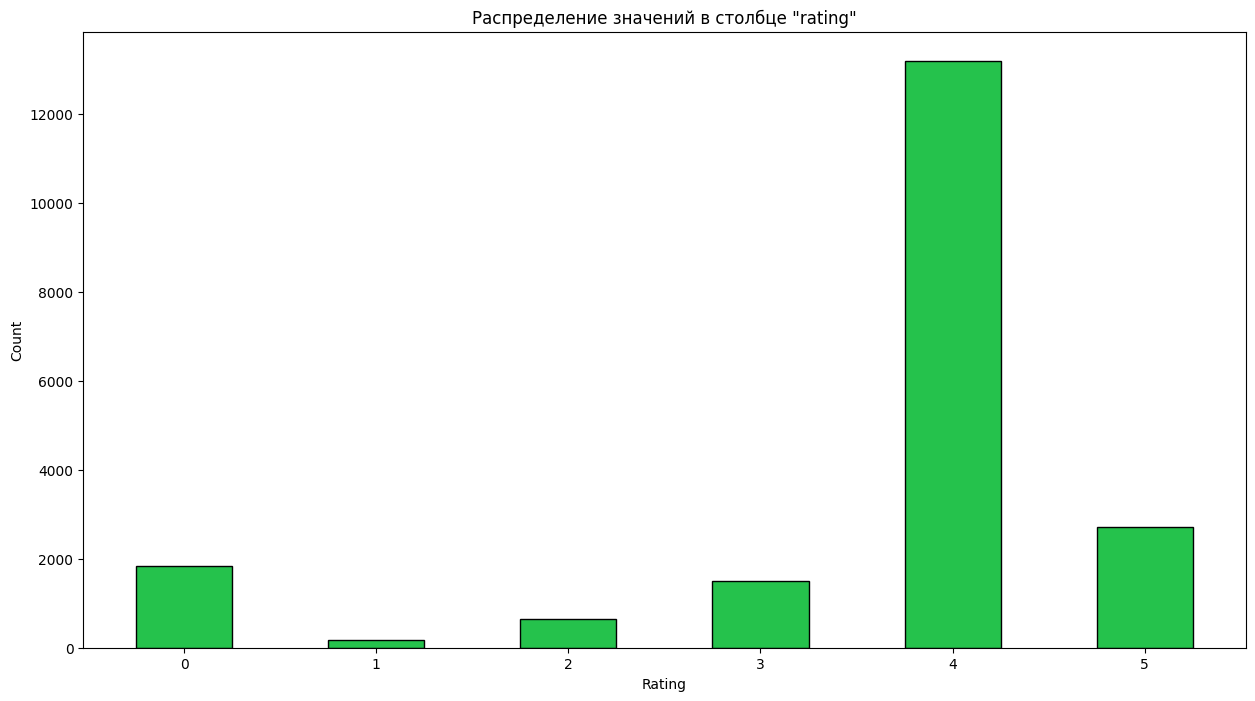

In [40]:
rating_distribution = df['rating'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(rating_distribution.index, rating_distribution.values, color='#25c24c', edgecolor='black', width=0.5)

plt.title('Распределение значений в столбце "rating"')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

In [41]:
X_clf = df.drop(columns=['rating'])
y_clf = df['rating']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=21)

## Individual Classificators

In [42]:
def choose_clsf(grid_models, models_name, X_train, X_test, y_train, y_test):
    
    best_accuracy = 0
    best_model_name = ''
    
    for index, model_name in models_name.items():
        
        grid_model = grid_models[index]
        
        grid_model.fit(X_train, y_train)
        
        best_model = grid_model.best_estimator_
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        
        print(f'Model: {model_name}')
        print(f'Best params: {grid_model.best_params_}')
        print(f'Train accuracy: {accuracy_train:.4f}')
        print(f'Test accuracy: {accuracy_test:.4f}')
        print(f'Crossval best result: {grid_model.best_score_:.4f}')
        print('-------------------------------')
        
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_name = model_name
            
    print(f'Best model is {best_model_name}')

In [43]:
forest = RandomForestClassifier(random_state=21)
tree = DecisionTreeClassifier(random_state=21)

forest_params = {
    'n_estimators': [5, 10, 50, 100], 
    'max_depth': [1, 10, 20, 30],  
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

tree_params = {
    'max_depth': [1, 5, 10, 20, 40], 
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}


grid_frc = GridSearchCV(forest, param_grid=forest_params, scoring='accuracy', cv=5, n_jobs=-1)
grid_dtc = GridSearchCV(tree, param_grid=tree_params, scoring='accuracy', cv=5, n_jobs=-1)

grids = [grid_frc, grid_dtc]
grid_dict = {
    0: 'RandomForestClassifier',
    1: 'DecisionTreeClassifier',
}

In [44]:
choose_clsf(grids, grid_dict, X_train1, X_test1, y_train1, y_test1)

Model: RandomForestClassifier
Best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}
Train accuracy: 0.7173
Test accuracy: 0.6739
Crossval best result: 0.6726
-------------------------------
Model: DecisionTreeClassifier
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5}
Train accuracy: 0.6683
Test accuracy: 0.6664
Crossval best result: 0.6661
-------------------------------
Best model is RandomForestClassifier


## Naive classificator

In [45]:
most_common = int(df['rating'].mode()[0])
print(f'Most popular rating: {most_common}')

Most popular rating: 4


In [46]:
y_naive = pd.Series([most_common] * 20052)

naive_accuracy = accuracy_score(y_clf, y_naive)

print(f'Naive accuracy: {naive_accuracy:.4f}')

Naive accuracy: 0.6577


# Датафрейм с rating: «плохо» (0, 1), «так себе» (2, 3), «отлично» (4, 5)

In [47]:
def categorize(value):
    if value in (0, 1):
        return 'bad'
    elif value in (2, 3):
        return 'so-so'
    elif value in (4, 5):
        return 'great'

df['rating'] = df['rating'].apply(categorize)
df

,rating,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,arugula,...,watermelon,whiskey,white wine,wild rice,wine,yellow squash,yogurt,yuca,zucchini,turkey
0,so-so,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,great,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,great,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,great,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,so-so,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,so-so,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20048,great,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20049,great,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20050,great,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


с помощью энкодера преобразуем целевую переменную

In [48]:
encoder = LabelEncoder()
df['rating'] = encoder.fit_transform(df['rating'])
df

,rating,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,arugula,...,watermelon,whiskey,white wine,wild rice,wine,yellow squash,yogurt,yuca,zucchini,turkey
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20048,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20049,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20050,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


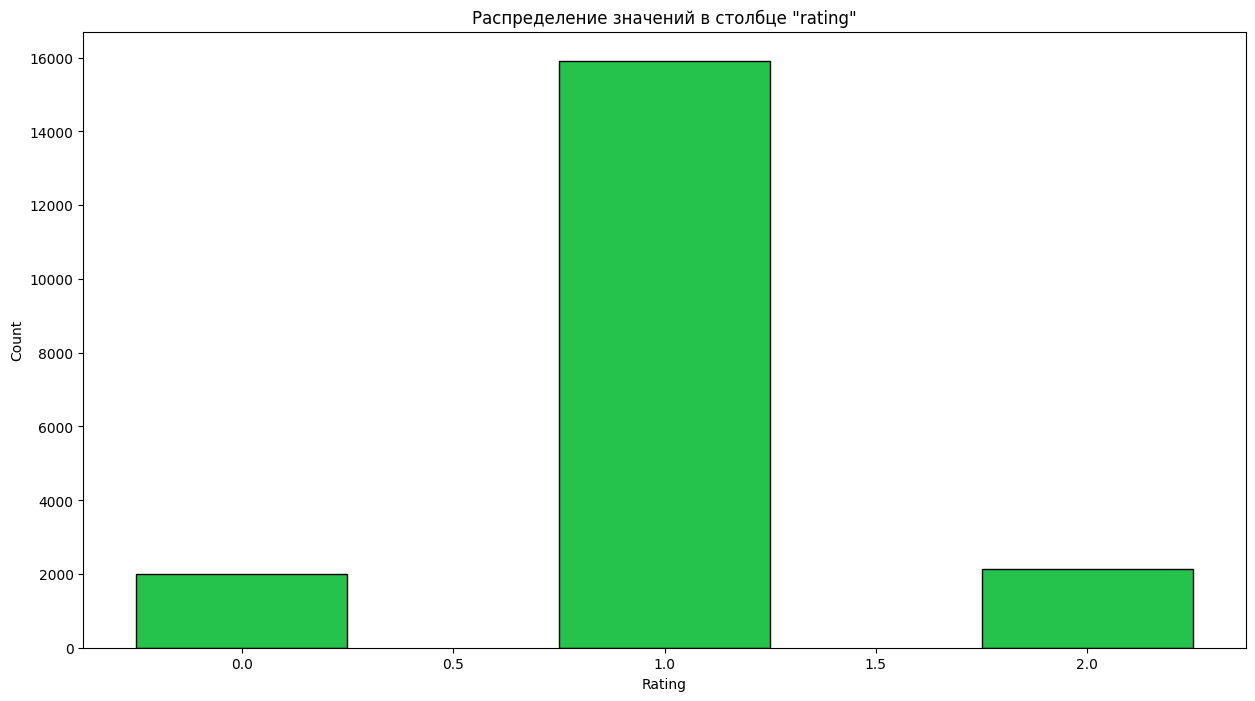

In [49]:
rating_distribution = df['rating'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(rating_distribution.index, rating_distribution.values, color='#25c24c', edgecolor='black', width=0.5)

plt.title('Распределение значений в столбце "rating"')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

In [50]:
X_clf = df.drop(columns=['rating'])
y_clf = df['rating']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=21)

Снова обучаем модели

In [51]:
choose_clsf(grids, grid_dict, X_train1, X_test1, y_train1, y_test1)

Model: RandomForestClassifier
Best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}
Train accuracy: 0.8214
Test accuracy: 0.8038
Crossval best result: 0.8016
-------------------------------


Model: DecisionTreeClassifier
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5}
Train accuracy: 0.8024
Test accuracy: 0.8003
Crossval best result: 0.7993
-------------------------------
Best model is RandomForestClassifier


точность гораздо повысилась

### Naive classificator

In [52]:
most_common = int(df['rating'].mode()[0])
print(f'Most popular rating: {most_common}')

Most popular rating: 1


In [53]:
y_naive = pd.Series([most_common] * 20052)

naive_accuracy = accuracy_score(y_clf, y_naive)

print(f'Naive accuracy: {naive_accuracy:.4f}')

Naive accuracy: 0.7933


# Other metrics

добавим в функцию другие метрики

In [54]:
def choose_clsf_metrics(grid_models, models_name, X_train, X_test, y_train, y_test):
    
    best_accuracy = 0
    best_model_name = ''
    
    for index, model_name in models_name.items():
        
        grid_model = grid_models[index]
        
        grid_model.fit(X_train, y_train)
        
        best_model = grid_model.best_estimator_
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        
        print(f'Model: {model_name}')
        print(f'Best params: {grid_model.best_params_}')
        print(f'Train accuracy: {accuracy_train:.4f}')
        print(f'Test accuracy: {accuracy_test:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Crossval best result: {grid_model.best_score_:.4f}')
        print('-------------------------------')
        
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model_name = model_name
            
    print(f'Best model is {best_model_name}')

In [55]:
forest = RandomForestClassifier(random_state=21)
tree = DecisionTreeClassifier(random_state=21)

forest_params = {
    'n_estimators': [5, 10, 50, 100], 
    'max_depth': [1, 10, 20, 30],  
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

tree_params = {
    'max_depth': [1, 5, 10, 20, 40], 
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}


grid_frc = GridSearchCV(forest, param_grid=forest_params, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_dtc = GridSearchCV(tree, param_grid=tree_params, scoring='f1_weighted', cv=5, n_jobs=-1)

grids = [grid_frc, grid_dtc]
grid_dict = {
    0: 'RandomForestClassifier',
    1: 'DecisionTreeClassifier',
}

In [56]:
choose_clsf_metrics(grids, grid_dict, X_train1, X_test1, y_train1, y_test1)

Model: RandomForestClassifier
Best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 5}
Train accuracy: 0.8231
Test accuracy: 0.8013
Precision: 0.7511
Recall: 0.8013
F1 Score: 0.7325
Crossval best result: 0.7285
-------------------------------


Model: DecisionTreeClassifier
Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 40}
Train accuracy: 0.8630
Test accuracy: 0.7806
Precision: 0.7178
Recall: 0.7806
F1 Score: 0.7362
Crossval best result: 0.7294
-------------------------------
Best model is RandomForestClassifier


# Classificator Ensembles

## Voiting

In [57]:
forest = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=30, n_estimators=5)
tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=40)

In [58]:
voting_clf = VotingClassifier(estimators=[('dt', tree), ('rf', forest)], voting='soft')
voting_clf.fit(X_train1, y_train1)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=40)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=30,
                                                     n_estimators=5))],
                 voting='soft')

In [59]:
y_test_pred = voting_clf.predict(X_test1)

f1 = f1_score(y_test1, y_test_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.7344


## Bagging

In [60]:
bagging_clf = BaggingClassifier(tree, n_estimators=50, random_state=21)
bagging_clf.fit(X_train1, y_train1)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=40),
                  n_estimators=50, random_state=21)

In [61]:
y_test_pred = bagging_clf.predict(X_test1)

f1 = f1_score(y_test1, y_test_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.7420


## Stacking

In [62]:
stacking_clf = StackingClassifier(
        estimators=[('dt', tree), ('rf', forest)],
        final_estimator=LogisticRegression(solver='liblinear'),
        passthrough=True, 
        cv=5
)

stacking_clf.fit(X_train1, y_train1)

StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(max_depth=40)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=30,
                                                       n_estimators=5))],
                   final_estimator=LogisticRegression(solver='liblinear'),
                   passthrough=True)

In [63]:
y_test_pred = stacking_clf.predict(X_test1)

f1 = f1_score(y_test1, y_test_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.7315


## Boosting

In [64]:
cat_boost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, random_state=21,  custom_metric='F1' ,logging_level='Silent')

param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search_result = cat_boost.grid_search(param_grid, X=X_train1, y=y_train1, 
                                       cv=3, 
                                       stratified=True, 
                                       refit=True, verbose=0,)

In [65]:
print("Лучшие параметры:", grid_search_result['params'])

Лучшие параметры: {'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300}


In [66]:
y_pred = cat_boost.predict(X_test1)
f1 = f1_score(y_test1, y_pred, average='weighted')
print(f'F1 score: {f1:.4f}')

F1 score: 0.7332


## Naive classification

In [67]:
y_pred = pd.Series([1] * 20052)

f1 = f1_score(y_clf, y_pred, average='weighted')
print(f'F1 score: {f1:.4f}')

F1 score: 0.7018


# Save model

In [68]:
joblib.dump(cat_boost, 'cat_boost.pkl')
joblib.dump(bagging_clf, 'bagging_clf.pkl')

['bagging_clf.pkl']

In [69]:
c = joblib.load('cat_boost.pkl')
y_pred = c.predict(X_clf)

f1 = f1_score(y_clf, y_pred, average='weighted')
print(f'F1 score: {f1:.4f}')

F1 score: 0.7430


In [70]:
b = joblib.load('bagging_clf.pkl')
y_pred = b.predict(X_clf)

f1 = f1_score(y_clf, y_pred, average='weighted')
print(f'F1 score: {f1:.4f}')

F1 score: 0.7926


Выбираем bagging_clf

# Nutrition Facts

In [71]:
class Nutrions:
    def __init__(self, ingredients):
        self.ingredients = ingredients
        self. api_key = 'iC9ngWo410ENzodyIWavdpFTlrdvnBrA0DXdLmpF'
        
    def get_fdcid(self):

        ingredient_ids = {}

        for ingredient in self.ingredients:
            
            url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={ingredient}&api_key={self.api_key}'
            
            response = requests.get(url)
            
            if response.status_code == 200:
                search_results = response.json()
                for food in search_results['foods']:
                    if food['description'] == ingredient.upper(): 
                        ingredient_ids[food['description']] = food['fdcId']
            else:
                print(f'Error: {response.status_code} for {ingredient}')

        return ingredient_ids

    def get_nutrions(self, nut):
        
        ingredient_ids = self.get_fdcid()
        nutrient_data = {}
        
        lowered_nut = {item.lower() for item in nut}
        
        for ingredient, fdcid in ingredient_ids.items():
            
            url = f'https://api.nal.usda.gov/fdc/v1/food/{fdcid}?api_key={self.api_key}'
            
            response = requests.get(url)
            
            if response.status_code == 200:
                nutrient_info = response.json()
                nutrients = nutrient_info.get('foodNutrients', [])

                nutrient_details = {}
                for nutrient in nutrients:
                    if 'nutrient' in nutrient and 'name' in nutrient['nutrient']:
                        nutrient_name = nutrient['nutrient']['name'] 
                        nutrient_amount = nutrient['amount']  
                    
                    if nutrient_name and nutrient_amount is not None:
                        for part in nutrient_name.split(','):
                            if part.strip().lower() in lowered_nut:
                                nutrient_details[nutrient_name] = nutrient_amount

                nutrient_data[ingredient] = nutrient_details
            else:
                print(f'Error: {response.status_code} for {ingredient}')
                    
        return nutrient_data

In [72]:
ingredients = data.drop(columns=['rating']).columns.tolist()
len(ingredients)

379

In [73]:
nut = [
    "Total lipid (fat)", "Saturated fat", "Cholesterol", "Total carbohydrates", "Sodium", "Dietary Fiber", 
    "Protein", "Added sugars", "Vitamin A", "Vitamin C", "Calcium", "Iron", "Vitamin D", "Vitamin E", 
    "Vitamin K", "Thiamin", "Riboflavin", "Niacin", "Vitamin B6", "Folate", "Vitamin B12", "Biotin", 
    "Pantothenic acid", "Phosphorus", "Iodine", "Magnesium", "Zinc", "Selenium", "Copper", "Manganese", 
    "Chromium", "Molybdenum", "Chloride", "Potassium", "Choline", "Protein"
]


In [74]:
nutrients_df = pd.DataFrame(columns=nut, index=ingredients)

nutrients_df = nutrients_df.astype(float)
nutrients_df = nutrients_df.fillna(0.0)

nutrients_df

,Total lipid (fat),Saturated fat,Cholesterol,Total carbohydrates,Sodium,Dietary Fiber,Protein,Added sugars,Vitamin A,Vitamin C,...,Zinc,Selenium,Copper,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline,Protein
almond,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amaretto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anchovy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
apple,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow squash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yogurt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yuca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zucchini,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lowered_nut = {item.lower() for item in set(nut)}

for ingredient, nutris in nutrions_dict.items():
    for name, amount in nutris.items():
        for part in name.split(','):
            if part.lower().strip() in lowered_nut:
                nutrients_df.loc[ingredient.lower(), part] = amount

In [ ]:
nutrions_class = Nutrions(ingredients)
nutrions_dict = nutrions_class.get_nutrions(set(nut))
nutrients_df

,Total lipid (fat),Saturated fat,Cholesterol,Total carbohydrates,Sodium,Dietary Fiber,Protein,Added sugars,Vitamin A,Vitamin C,...,Zinc,Selenium,Copper,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline,Protein
almond,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
amaretto,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
anchovy,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
anise,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
apple,0.00,0.0,0.0,0.0,0.0,0.0,0.41,0.0,41.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow squash,0.00,0.0,0.0,0.0,10.0,0.0,1.00,0.0,200.0,16.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
yogurt,2.94,0.0,12.0,0.0,41.0,0.0,2.94,0.0,59.0,0.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.94
yuca,0.00,0.0,0.0,0.0,525.0,0.0,0.94,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.94
zucchini,0.00,0.0,0.0,0.0,0.0,0.0,1.05,0.0,0.0,12.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222.0,0.0,1.05


In [ ]:
nutrients_df.to_csv('nutrients.csv')

# Similar Recipes

In [2]:
df = pd.read_csv("nutrients.csv",index_col="Unnamed: 0")

In [3]:
df.head()

,Total lipid (fat),Saturated fat,Cholesterol,Total carbohydrates,Sodium,Dietary Fiber,Protein,Added sugars,Vitamin A,Vitamin C,...,Zinc,Selenium,Copper,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline,Protein.1
almond,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
amaretto,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
anchovy,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
anise,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
apple,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.0,41.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.41


In [4]:
index_list_df = df.index.to_list()

In [5]:
class SimilarRecipes:
    def __init__(self,index_list_df):
        self.index_list_df = index_list_df
    
    def get_recipe(self):
        
        ingredient_ids = {}

        for ingredient in self.index_list_df:
            url = f'https://www.epicurious.com/search?q={ingredient}&sort=most-reviewed'
            
            response = requests.get(url)
            
            if response.status_code == 200:
                try:
                    soup = BeautifulSoup(response.text, "html.parser")
                    div_tag = soup.find("div",class_="SummaryCollectionGridItems-DZShR fVPNxz hide-read-more-ad").find_next()
                    a_tag = div_tag.find_all("a")
                    link = f"https://www.epicurious.com{a_tag[1].get('href')}"
                    title = a_tag[1].text
                    raiting = div_tag.find("p",class_="BaseWrap-sc-gjQpdd BaseText-ewhhUZ RatingRating-btVmKd iUEiRd jjBDuu fOfiAf").text

                    ingredient_ids[ingredient] = [title,raiting,link]
                except:
                    ingredient_ids[ingredient] = [np.nan,np.nan,np.nan]
            else:
                print(f'Error: {response.status_code} for {ingredient}')

        return ingredient_ids

In [ ]:
dict_ingred = SimilarRecipes(index_list_df).get_recipe()

In [ ]:
df["title"] = np.nan
df["raitings"] = np.nan
df["links"] = np.nan

In [ ]:
for ingredient, list_features in dict_ingred.items():
    df.loc[ingredient,"title"] = list_features[0]
    df.loc[ingredient,"raitings"] = list_features[1]
    df.loc[ingredient,"links"] = list_features[2]

/tmp/ipykernel_47506/2008734721.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mixed Greens with Goat Cheese and Candied Almonds' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[ingredient,"title"] = list_features[0]
/tmp/ipykernel_47506/2008734721.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[ingredient,"raitings"] = list_features[1]
/tmp/ipykernel_47506/2008734721.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'https://www.epicurious.com/recipes/food/views/mixed-greens-with-goat-cheese-and-candied-almonds-104191' has dtype incompatible with float64, please explicitly cast to

In [ ]:
df["Total lipid (fat)"] = (round(df["Total lipid (fat)"] / 78 * 100).astype(int))%100
df["Saturated fat"] = (round(df["Saturated fat"] / 20 * 100).astype(int))%100
df["Cholesterol"] = (round(df["Cholesterol"] / 300 * 100).astype(int))%100
df["Total carbohydrates"] = (round(df["Total carbohydrates"] / 275 * 100).astype(int))%100
df["Sodium"] = (round(df["Sodium"] / 2300 * 100).astype(int))%100
df["Dietary Fiber"] = (round(df["Dietary Fiber"] / 28 * 100).astype(int))%100
df["Protein"] = (round(df["Protein"] / 50 * 100).astype(int))%100
df["Added sugars"] = (round(df["Added sugars"] / 50 * 100).astype(int))%100
df["Vitamin A"] = (round(df["Vitamin A"] / 900 * 100).astype(int))%100
df["Vitamin C"] = (round(df["Vitamin C"] / 90 * 100).astype(int))%100
df["Calcium"] = (round(df["Calcium"] / 1300 * 100).astype(int))%100
df["Iron"] = (round(df["Iron"] / 18 * 100).astype(int))%100
df["Vitamin D"] = (round(df["Vitamin D"] / 20 * 100).astype(int))%100
df["Vitamin E"] = (round(df["Vitamin E"] / 15 * 100).astype(int))%100
df["Vitamin K"] = (round(df["Vitamin K"] / 120 * 100).astype(int))%100
df["Thiamin"] = (round(df["Thiamin"] / 1.2 * 100).astype(int))%100
df["Riboflavin"] = (round(df["Riboflavin"] / 1.3 * 100).astype(int))%100
df["Niacin"] = (round(df["Niacin"] / 16 * 100).astype(int))%100
df["Vitamin B6"] = (round(df["Vitamin B6"] / 1.7 * 100).astype(int))%100
df["Folate"] = (round(df["Folate"] / 400 * 100).astype(int))%100
df["Vitamin B12"] = (round(df["Vitamin B12"] / 2.4 * 100).astype(int))%100
df["Biotin"] = (round(df["Biotin"] / 30 * 100).astype(int))%100
df["Pantothenic acid"] = (round(df["Pantothenic acid"] / 5 * 100).astype(int))%100
df["Phosphorus"] = (round(df["Phosphorus"] / 1250 * 100).astype(int))%100
df["Iodine"] = (round(df["Iodine"] / 150 * 100).astype(int))%100
df["Magnesium"] = (round(df["Magnesium"] / 420 * 100).astype(int))%100
df["Zinc"] = (round(df["Zinc"] / 11 * 100).astype(int))%100
df["Selenium"] = (round(df["Selenium"] / 55 * 100).astype(int))%100
df["Copper"] = (round(df["Copper"] / 0.9 * 100).astype(int))%100
df["Manganese"] = (round(df["Manganese"] / 2.3 * 100).astype(int))%100
df["Chromium"] = (round(df["Chromium"] / 35 * 100).astype(int))%100
df["Molybdenum"] = (round(df["Molybdenum"] / 45 * 100).astype(int))%100
df["Chloride"] = (round(df["Chloride"] / 2300 * 100).astype(int))%100
df["Potassium"] = (round(df["Potassium"] / 4700 * 100).astype(int))%100
df["Choline"] = (round(df["Choline"] / 550 * 100).astype(int))%100
df["Protein.1"] = (round(df["Protein.1"] / 50 * 100).astype(int))%100

In [ ]:
df.head()

,Total lipid (fat),Saturated fat,Cholesterol,Total carbohydrates,Sodium,Dietary Fiber,Protein,Added sugars,Vitamin A,Vitamin C,...,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline,Protein.1,title,raitings,links
almond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Mixed Greens with Goat Cheese and Candied Almonds,4.7,https://www.epicurious.com/recipes/food/views/...
amaretto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Chicken Tagine with Apricots and Spiced Pine Nuts,4.4,https://www.epicurious.com/recipes/food/views/...
anchovy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Sophisto Joes,4.0,https://www.epicurious.com/recipes/food/views/...
anise,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Anise-Almond Biscotti,5.0,https://www.epicurious.com/recipes/food/views/...
apple,0,0,0,0,0,0,1,0,5,2,...,0,0,0,0,2,0,1,Best Cocoa Brownies,4.4,https://www.epicurious.com/recipes/food/views/...


In [ ]:
df.to_csv("new_nutrients.csv")